<a href="https://colab.research.google.com/github/angelinux/soybean-cnn-numpy/blob/master/Soybean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Soybean CNN Classifier

## Gathering data

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d fpeccia/weed-detection-in-soybean-crops
!rm -rf dataset
!unzip weed-detection-in-soybean-crops.zip
!rm -rf dataset/dataset

In [0]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split
from random import shuffle
from random import randint
from google.colab.patches import cv2_imshow

In [0]:
sz = 64
classes = os.listdir('dataset')
n_filters = 8

old_prefix = 'dataset/'
new_prefix = 'dataset-transf/'

In [0]:
def transform_image(image_name):
  image = cv2.imread(image_name, cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image, (sz,sz))
  image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  return image

In [0]:
shutil.rmtree(new_prefix, ignore_errors=True)
os.mkdir(new_prefix)
for i in range(len(classes)):
  os.mkdir(new_prefix + classes[i])
  for f in os.listdir(old_prefix + classes[i]):
    image = transform_image(os.path.join(old_prefix+classes[i], f))
    cv2.imwrite(os.path.join(new_prefix+classes[i], f), image)

In [0]:
alldata = list()
for i in range(len(classes)):
  for f in os.listdir(new_prefix+classes[i]):
    alldata.append([cv2.imread(os.path.join(new_prefix+classes[i], f), cv2.IMREAD_UNCHANGED), i])

data_train, data_test = train_test_split(alldata, test_size=0.3)

In [128]:
print(len(data_train))

10735


## CNN component definition

In [0]:
class Convolution3x3:
  #class for convolution with 3x3 filters
  
  def __init__(self, num_filters):
    self.num_filters = num_filters

    # filters is a 3d array with dimensions (num_filters, 3, 3)
    # We divide by 9 to reduce the variance of our initial values
    self.filters = np.random.randn(num_filters, 3, 3) / 9    

  def iterate_regions(self, image):
    '''
    Generates all possible 3x3 image regions using valid padding.
    - image is a 2d numpy array.
    '''
    h, w = image.shape

    for i in range(h - 2):
      for j in range(w - 2):
        im_region = image[i:(i + 3), j:(j + 3)]
        yield im_region, i, j        

  def forward(self, input):
    '''
    Performs a forward pass of the conv layer using the given input.
    Returns a 3d numpy array with dimensions (h, w, num_filters).
    - input is a 2d numpy array
    '''
    self.last_input = input

    h, w = input.shape
    output = np.zeros((h - 2, w - 2, self.num_filters))

    for im_region, i, j in self.iterate_regions(input):
      output[i, j] = np.sum(im_region * self.filters, axis=(1, 2))

    return output 
  

  def backprop(self, d_L_d_out, learn_rate):
    '''
    Performs a backward pass of the conv layer.
    - d_L_d_out is the loss gradient for this layer's outputs.
    - learn_rate is a float.
    '''
    d_L_d_filters = np.zeros(self.filters.shape)

    for im_region, i, j in self.iterate_regions(self.last_input):
      for f in range(self.num_filters):
        d_L_d_filters[f] += d_L_d_out[i, j, f] * im_region

    # Update filters
    self.filters -= learn_rate * d_L_d_filters

    # We aren't returning anything here since we use Conv3x3 as the first layer in our CNN.
    # Otherwise, we'd need to return the loss gradient for this layer's inputs, just like every
    # other layer in our CNN.
    return None

  

In [0]:
class MaxPool2:
  # A Max Pooling layer using a pool size of 2.

  def iterate_regions(self, image):
    '''
    Generates non-overlapping 2x2 image regions to pool over.
    - image is a 2d numpy array
    '''
    h, w, _ = image.shape
    new_h = h // 2
    new_w = w // 2

    for i in range(new_h):
      for j in range(new_w):
        im_region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
        yield im_region, i, j

  def forward(self, input):
    '''
    Performs a forward pass of the maxpool layer using the given input.
    Returns a 3d numpy array with dimensions (h / 2, w / 2, num_filters).
    - input is a 3d numpy array with dimensions (h, w, num_filters)
    '''
    self.last_input = input

    h, w, num_filters = input.shape
    output = np.zeros((h // 2, w // 2, num_filters))

    for im_region, i, j in self.iterate_regions(input):
      output[i, j] = np.amax(im_region, axis=(0, 1))

    return output

  def backprop(self, d_L_d_out):
    '''
    Performs a backward pass of the maxpool layer.
    Returns the loss gradient for this layer's inputs.
    - d_L_d_out is the loss gradient for this layer's outputs.
    '''
    d_L_d_input = np.zeros(self.last_input.shape)

    for im_region, i, j in self.iterate_regions(self.last_input):
      h, w, f = im_region.shape
      amax = np.amax(im_region, axis=(0, 1))

      for i2 in range(h):
        for j2 in range(w):
          for f2 in range(f):
            # If this pixel was the max value, copy the gradient to it.
            if im_region[i2, j2, f2] == amax[f2]:
              d_L_d_input[i * 2 + i2, j * 2 + j2, f2] = d_L_d_out[i, j, f2]

    return d_L_d_input

In [0]:
class Softmax:
  # A standard fully-connected layer with softmax activation.

  def __init__(self, input_len, nodes):
    # We divide by input_len to reduce the variance of our initial values
    self.weights = np.random.randn(input_len, nodes) / input_len
    self.biases = np.zeros(nodes)

  def forward(self, input):
    '''
    Performs a forward pass of the softmax layer using the given input.
    Returns a 1d numpy array containing the respective probability values.
    - input can be any array with any dimensions.
    '''
    self.last_input_shape = input.shape

    input = input.flatten()
    self.last_input = input

    input_len, nodes = self.weights.shape

    totals = np.dot(input, self.weights) + self.biases
    self.last_totals = totals

    exp = np.exp(totals)
    return exp / np.sum(exp, axis=0)

  def backprop(self, d_L_d_out, learn_rate):
    '''
    Performs a backward pass of the softmax layer.
    Returns the loss gradient for this layer's inputs.
    - d_L_d_out is the loss gradient for this layer's outputs.
    - learn_rate is a float.
    '''
    # We know only 1 element of d_L_d_out will be nonzero
    for i, gradient in enumerate(d_L_d_out):
      if gradient == 0:
        continue

      # e^totals
      t_exp = np.exp(self.last_totals)

      # Sum of all e^totals
      S = np.sum(t_exp)

      # Gradients of out[i] against totals
      d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
      d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)

      # Gradients of totals against weights/biases/input
      d_t_d_w = self.last_input
      d_t_d_b = 1
      d_t_d_inputs = self.weights

      # Gradients of loss against totals
      d_L_d_t = gradient * d_out_d_t

      # Gradients of loss against weights/biases/input
      d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
      d_L_d_b = d_L_d_t * d_t_d_b
      d_L_d_inputs = d_t_d_inputs @ d_L_d_t

      # Update weights / biases
      self.weights -= learn_rate * d_L_d_w
      self.biases -= learn_rate * d_L_d_b

      return d_L_d_inputs.reshape(self.last_input_shape)

## Training

In [129]:
conv = Convolution3x3(n_filters)
pool = MaxPool2()
softmax = Softmax((sz//2-1)*(sz//2-1)*n_filters, len(classes))



def forward(image, label):
  '''
  Completes a forward pass of the CNN and calculates the accuracy and
  cross-entropy loss.
  - image is a 2d numpy array
  - label is a digit
  '''
  # We transform the image from [0, 255] to [-0.5, 0.5] to make it easier
  # to work with. This is standard practice.
  out = conv.forward((image / 255) - 0.5)
  out = pool.forward(out)
  out = softmax.forward(out)

  # Calculate cross-entropy loss and accuracy. np.log() is the natural log.
  loss = -np.log(out[label])
  acc = 1 if np.argmax(out) == label else 0

  return out, loss, acc

def train(im, label, lr=.005):
  '''
  Completes a full training step on the given image and label.
  Returns the cross-entropy loss and accuracy.
  - image is a 2d numpy array
  - label is a digit
  - lr is the learning rate
  '''
  # Forward
  out, loss, acc = forward(im, label)

  # Calculate initial gradient
  gradient = np.zeros(len(classes))
  gradient[label] = -1 / out[label]

  # Backprop
  gradient = softmax.backprop(gradient, lr)
  gradient = pool.backprop(gradient)
  gradient = conv.backprop(gradient, lr)

  return loss, acc


# Train the CNN for 3 epochs
for epoch in range(3):
  print('--- Epoch %d ---' % (epoch + 1))

  # Shuffle the training data
  shuffle(data_train)

  # Train!
  loss = 0
  num_correct = 0
  for i, item in enumerate(data_train[:10000]):
    if i > 0 and i % 100 == 99:
      print(
        '[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %
        (i + 1, loss / 100, num_correct)
      )
      loss = 0
      num_correct = 0

    l, acc = train(item[0], item[1])
    loss += l
    num_correct += acc


--- Epoch 1 ---
[Step 100] Past 100 steps: Average Loss 1.306 | Accuracy: 38%
[Step 200] Past 100 steps: Average Loss 1.203 | Accuracy: 45%
[Step 300] Past 100 steps: Average Loss 1.248 | Accuracy: 43%
[Step 400] Past 100 steps: Average Loss 1.234 | Accuracy: 50%
[Step 500] Past 100 steps: Average Loss 1.169 | Accuracy: 52%
[Step 600] Past 100 steps: Average Loss 1.155 | Accuracy: 56%
[Step 700] Past 100 steps: Average Loss 1.223 | Accuracy: 54%
[Step 800] Past 100 steps: Average Loss 1.132 | Accuracy: 53%
[Step 900] Past 100 steps: Average Loss 1.245 | Accuracy: 46%
[Step 1000] Past 100 steps: Average Loss 1.147 | Accuracy: 52%
[Step 1100] Past 100 steps: Average Loss 1.119 | Accuracy: 56%
[Step 1200] Past 100 steps: Average Loss 0.990 | Accuracy: 57%
[Step 1300] Past 100 steps: Average Loss 1.146 | Accuracy: 54%
[Step 1400] Past 100 steps: Average Loss 1.121 | Accuracy: 54%
[Step 1500] Past 100 steps: Average Loss 1.271 | Accuracy: 47%
[Step 1600] Past 100 steps: Average Loss 1.110 |

## Testing

In [130]:
# Test the CNN
print('\n--- Testing the CNN ---')
loss = 0
num_correct = 0
for item in data_test[:500]:
  _, l, acc = forward(item[0], item[1])
  loss += l
  num_correct += acc

num_tests = len(data_test[:500])
print('Test Loss:', loss / num_tests)
print('Test Accuracy:', num_correct / num_tests)


--- Testing the CNN ---
Test Loss: 0.9759738998987465
Test Accuracy: 0.636


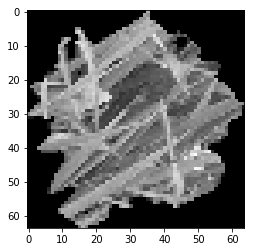

Actual class:  grass
Predicted class:  grass
---------


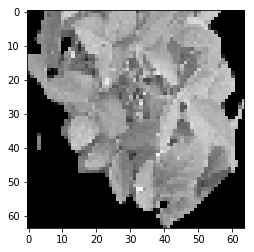

Actual class:  soybean
Predicted class:  soybean
---------


In [132]:
for j in range(2):
  index = randint(0, len(data_test))
  image, label = data_test[index]
  plt.figure()
  plt.imshow(image, cmap='gray')
  plt.show()
  print("Actual class: ", classes[label])
  pred, l, acc = forward(image, label)
  print("Predicted class: ", classes[np.argmax(pred)])
  print("---------")

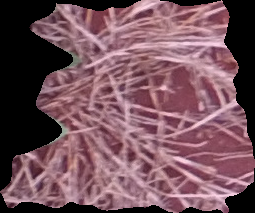

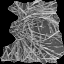

Actual class:  soil
Predicted class:  soil


In [142]:
cl = randint(0, len(classes))
num = randint(0, 1000)
image = cv2.imread(old_prefix + classes[cl] + '/' + str(num) +'.tif')
cv2_imshow(image)
image = cv2.imread(new_prefix + classes[cl] + '/' + str(num) +'.tif', cv2.IMREAD_UNCHANGED)
cv2_imshow(image)
print("Actual class: ", classes[cl])
pred, l, acc = forward(image, cl)
print("Predicted class: ", classes[np.argmax(pred)])

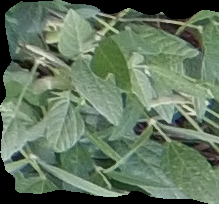

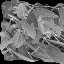

Actual class:  soybean
Predicted class:  soybean


In [143]:
cl = randint(0, len(classes))
num = randint(0, 1000)
image = cv2.imread(old_prefix + classes[cl] + '/' + str(num) +'.tif')
cv2_imshow(image)
image = cv2.imread(new_prefix + classes[cl] + '/' + str(num) +'.tif', cv2.IMREAD_UNCHANGED)
cv2_imshow(image)
print("Actual class: ", classes[cl])
pred, l, acc = forward(image, cl)
print("Predicted class: ", classes[np.argmax(pred)])